# Calibrating a differential equation using Hamiltonian Monte Carlo algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## First Example: Hamiltonian Monte Carlo (HMC) Implementation


### **Overview**
This implementation performs Bayesian inference using **Hamiltonian Monte Carlo (HMC)** to estimate the posterior distribution of a parameter $\mu$. The target posterior distribution is based on a **Gaussian prior** and a **Gaussian likelihood function**.

### **Problem Setup**
We simulate a dataset with **50 observations**, assuming that the true mean $\mu$ is **2.5**, and the variance is known (**1.0**). The goal is to infer $\mu$ using HMC.

- **Prior Distribution:**
  $$ P(\mu) \sim \mathcal{N}(\mu_0, \tau^2) $$
  where $\mu_0 = 0.0$ and $\tau^2 = 10.0$.

- **Likelihood Function:**
  $$ P(data | \mu) \sim \mathcal{N}(\mu, \sigma^2) $$
  where $\sigma^2 = 1.0$.

- **Posterior Distribution:**
  $$ P(\mu | data) \propto P(data | \mu) P(\mu) $$


In [2]:
# Problem parameters
np.random.seed(42)
n = 150                     # Number of data points
sigma2 = 10.0               # Known variance of the data
mu_real = 2.5              # Real value of the mean
datos = np.random.normal(mu_real, np.sqrt(sigma2), size=n)  # Simulated data


mu0 = 0.0                  # Prior mean
tau2 = 1.0                 # Prior variance

### **Implementation Details**
#### **Potential Energy Function**
The Hamiltonian formulation introduces a potential energy function $U(\mu)$, which is the negative log posterior:

```python
# Potential Energy Function U(q) = -log(P(mu | data))
def U(mu):
    log_prior = -0.5 * ((mu - mu0)**2 / tau2)
    log_likelihood = -0.5 * np.sum((data - mu)**2 / sigma2)
    return - (log_prior + log_likelihood)
```

#### **Gradient of Potential Energy**
The gradient $\nabla U(\mu)$ is required for Leapfrog integration:

```python
# Gradient of U(q)
def grad_U(mu):
    grad_prior = (mu - mu0) / tau2
    grad_likelihood = np.sum(mu - data) / sigma2
    return grad_prior + grad_likelihood
```


In [3]:
def U(mu):
    log_prior = -0.5 * ((mu - mu0)**2 / tau2)
    log_likelihood = -0.5 * np.sum((datos - mu)**2 / sigma2)
    return - (log_prior + log_likelihood)


def grad_U(mu):
    grad_prior = (mu - mu0) / tau2
    grad_likelihood = np.sum(mu - datos) / sigma2
    return grad_prior + grad_likelihood


#### **HMC Iteration with Leapfrog Integration**
Each iteration of HMC updates $\mu$ using **Leapfrog integration**, ensuring energy conservation:

```python
# Perform one HMC iteration
def hmc_iteration(U, grad_U, epsilon, L, current_q, std_dev):
    q = np.copy(current_q)
    p = np.random.normal(0, std_dev, size=1)  # Initial momentum
    current_p = np.copy(p)

    # First half-step for momentum
    p -= epsilon * grad_U(q) / 2

    for i in range(L):
        q += epsilon * p  # Full step for position
        if i != L - 1:
            p -= epsilon * grad_U(q)  # Full step for momentum

    p -= epsilon * grad_U(q) / 2  # Last half-step
    p = -p  # Negate momentum for reversibility

    # Compute energies
    current_U = U(current_q)
    current_K = np.dot(current_p, current_p) / 2
    proposed_U = U(q)
    proposed_K = np.dot(p, p) / 2

    # Metropolis-Hastings acceptance step
    if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q
    else:
        return current_q
```

#### **Full HMC Sampling Process**
The HMC sampler runs multiple iterations to generate posterior samples:

```python
# Run HMC sampling
def hmc(mu_init, num_samples=5000, epsilon=0.1, L=20, std_dev=1.0):
    samples = np.zeros(num_samples)
    mu = np.array([mu_init])  # Initialize as array

    for i in range(num_samples):
        mu = hmc_iteration(U, grad_U, epsilon, L, mu, std_dev)
        samples[i] = mu  # Store sample

    return samples
```

In [ ]:
def hmc_iteration(U, grad_U, epsilon, L, current_q, std_dev):
    q = np.copy(current_q)
    p = np.random.normal(0, std_dev, size=1)  
    current_p = np.copy(p)

    
    p -= epsilon * grad_U(q) / 2

    for i in range(L):
        q += epsilon * p  
        if i != L - 1:
            p -= epsilon * grad_U(q)  

    p -= epsilon * grad_U(q) / 2  
    p = -p  

  
    current_U = U(current_q)
    current_K = np.dot(current_p, current_p) / 2
    proposed_U = U(q)
    proposed_K = np.dot(p, p) / 2

   
    if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q
    else:
        return current_q
    
def hmc(mu_init, num_samples=5000, epsilon=0.1, L=20, std_dev=1.0):
    samples = np.zeros(num_samples)
    mu = np.array([mu_init]) 

    for i in range(num_samples):
        mu = hmc_iteration(U, grad_U, epsilon, L, mu, std_dev)
        samples[i] = mu  

    return samples


### **Results and Visualization**
We initialize $\mu$ at **0.0**, run HMC, and plot the posterior distribution.

In [6]:
# 🔥 Execution
mu_init = 0.0
samples = hmc(mu_init)

C:\Users\carlo\AppData\Local\Temp\ipykernel_1712\4200374010.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i] = mu


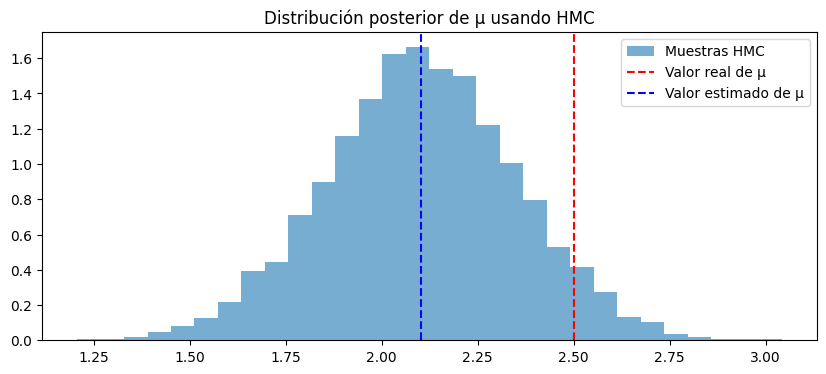

In [7]:
# Plot results
plt.figure(figsize=(10, 4))
plt.hist(samples, bins=30, density=True, alpha=0.6, label="Muestras HMC")
plt.axvline(mu_real, color="red", linestyle="--", label="Valor real de μ")
plt.axvline(np.mean(samples), color="blue", linestyle="--", label="Valor estimado de μ")
plt.legend()
plt.title("Distribución posterior de μ usando HMC")
plt.show()

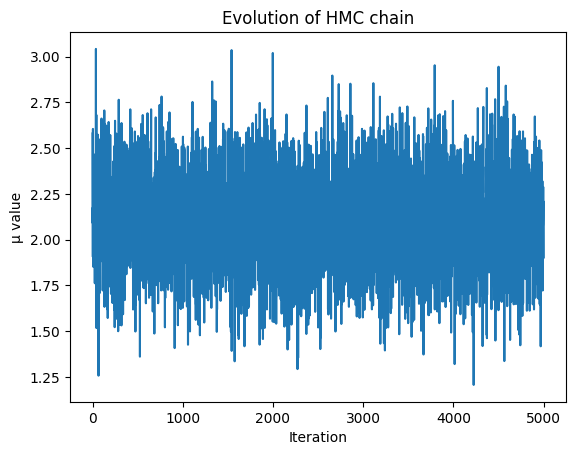

In [10]:
# Chain evolution
plt.plot(samples)
plt.xlabel("Iteration")
plt.ylabel("μ value")
plt.title("Evolution of HMC chain")
plt.show()

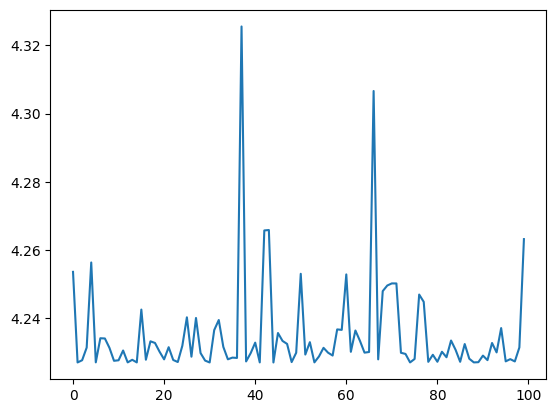

In [27]:
plt.plot([np.log(U(q)) for q in samples[:100]])

## Second example

C:\Users\carlo\AppData\Local\Temp\ipykernel_1712\107766091.py:20: RuntimeWarning: invalid value encountered in log
  log_prior_sigma2 = -(alpha + 1) * np.log(sigma2) - beta / sigma2
C:\Users\carlo\AppData\Local\Temp\ipykernel_1712\107766091.py:21: RuntimeWarning: invalid value encountered in log
  log_likelihood = -0.5 * np.sum((datos - mu)**2 / sigma2) - (n/2) * np.log(sigma2)


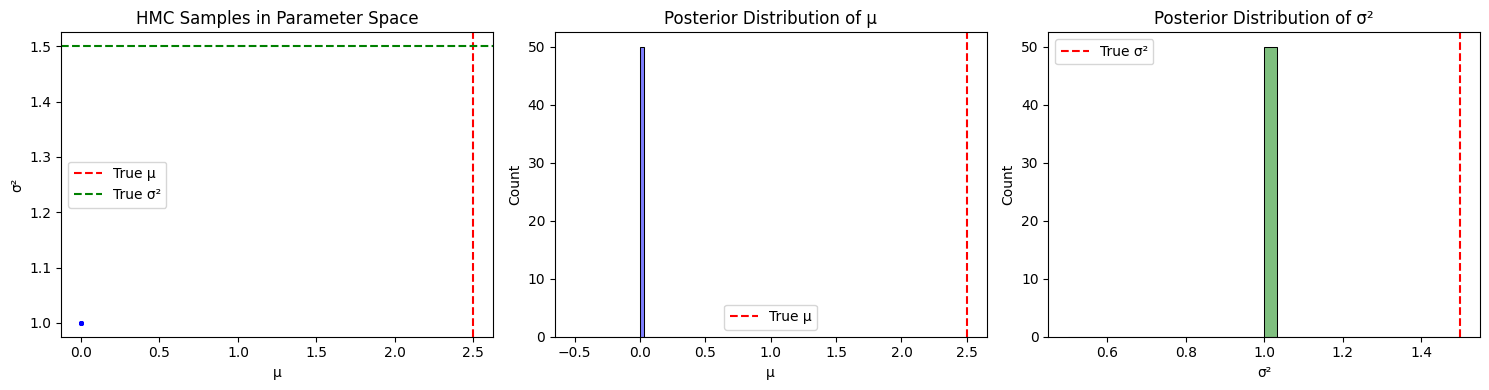

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔥 Parámetros del problema
np.random.seed(42)
n = 50                         # Número de datos
mu_real = 2.5                  # Valor real de mu
sigma2_real = 1.5              # Valor real de sigma^2
datos = np.random.normal(mu_real, np.sqrt(sigma2_real), size=n)  # Datos simulados

# 🔥 Priori para los parámetros
mu0, tau2 = 0.0, 1.0           # Prior para mu: Normal(0,1)
alpha, beta = 2.0, 2.0         # Prior para sigma^2: Inversa-Gamma(2,2)

# 🔥 Energía Potencial U(q) = -log(P(μ, σ^2 | datos))
def U(theta):
    mu, sigma2 = theta
    log_prior_mu = -0.5 * ((mu - mu0)**2 / tau2)
    log_prior_sigma2 = -(alpha + 1) * np.log(sigma2) - beta / sigma2
    log_likelihood = -0.5 * np.sum((datos - mu)**2 / sigma2) - (n/2) * np.log(sigma2)
    return - (log_prior_mu + log_prior_sigma2 + log_likelihood)

# 🔥 Gradiente de U(q)
def grad_U(theta):
    mu, sigma2 = theta
    grad_mu = (mu - mu0) / tau2 + np.sum(mu - datos) / sigma2
    grad_sigma2 = -(alpha + 1) / sigma2 + beta / sigma2**2 + 0.5 * np.sum((datos - mu)**2) / sigma2**2 - n / (2 * sigma2)
    return np.array([grad_mu, grad_sigma2])

# 🔥 Iteración de HMC con Leapfrog Integration
def hmc_iteration(U, grad_U, epsilon, L, current_q, std_dev):
    q = np.copy(current_q)
    p = np.random.normal(0, std_dev, size=len(q))  # Momento inicial
    current_p = np.copy(p)

    # Primer medio paso de momentum
    p -= epsilon * grad_U(q) / 2

    for i in range(L):
        q += epsilon * p  # Paso completo para posición
        if i != L - 1:
            p -= epsilon * grad_U(q)  # Paso completo para momentum

    p -= epsilon * grad_U(q) / 2  # Último medio paso
    p = -p  # Negar el momentum para reversibilidad

    # Cálculo de energías
    current_U = U(current_q)
    current_K = np.dot(current_p, current_p) / 2
    proposed_U = U(q)
    proposed_K = np.dot(p, p) / 2

    # Aceptar o rechazar
    if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q
    else:
        return current_q

# 🔥 Algoritmo HMC completo
def hmc(mu_init, sigma2_init, num_samples=50, epsilon=0.1, L=20, std_dev=1.0):
    samples = np.zeros((num_samples, 2))
    theta = np.array([mu_init, sigma2_init])

    for i in range(num_samples):
        theta = hmc_iteration(U, grad_U, epsilon, L, theta, std_dev)
        samples[i] = theta  # Guardar muestras

    return samples

# 🔥 Correr HMC
mu_init, sigma2_init = 0.0, 1.0
samples = hmc(mu_init, sigma2_init)

# 🔥 Visualizar los resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 📌 1. Distribución conjunta en el espacio de parámetros (2D)
axes[0].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=5, color='blue')
axes[0].axvline(mu_real, color="red", linestyle="--", label="True μ")
axes[0].axhline(sigma2_real, color="green", linestyle="--", label="True σ²")
axes[0].set_xlabel("μ")
axes[0].set_ylabel("σ²")
axes[0].set_title("HMC Samples in Parameter Space")
axes[0].legend()

# 📌 2. Histograma de μ
sns.histplot(samples[:, 0], bins=30, kde=True, ax=axes[1], color='blue')
axes[1].axvline(mu_real, color="red", linestyle="--", label="True μ")
axes[1].set_xlabel("μ")
axes[1].set_title("Posterior Distribution of μ")
axes[1].legend()

# 📌 3. Histograma de σ²
sns.histplot(samples[:, 1], bins=30, kde=True, ax=axes[2], color='green')
axes[2].axvline(sigma2_real, color="red", linestyle="--", label="True σ²")
axes[2].set_xlabel("σ²")
axes[2].set_title("Posterior Distribution of σ²")
axes[2].legend()

plt.tight_layout()
plt.show()


## Third example: Use of HMC algorithm in a differential equation

In [ ]:
## D